In [2]:
import numpy as np
from scipy.stats import multivariate_normal


Animation saved as: /Users/leo/Desktop/MI_tool/inverse_analysis/gmm/gmm_animation_varied_clusters.gif


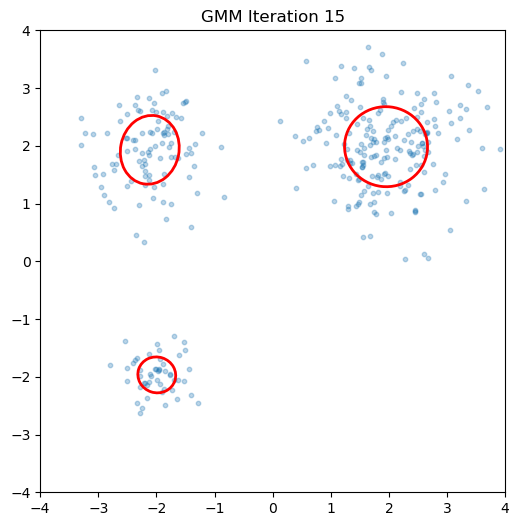

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import multivariate_normal
import os

# Step 1: Generate synthetic clusters of varying size and density
def generate_varied_clusters():
    np.random.seed(0)
    cluster_configs = [
        {"mean": [-2, -2], "cov": 0.1 * np.eye(2), "n": 50},
        {"mean": [2, 2],   "cov": 0.5 * np.eye(2), "n": 200},
        {"mean": [-2, 2],  "cov": 0.3 * np.eye(2), "n": 100}
    ]
    
    clusters = []
    for config in cluster_configs:
        points = np.random.multivariate_normal(config["mean"], config["cov"], config["n"])
        clusters.append(points)
    
    X = np.vstack(clusters)
    y = np.array([np.sin(x[0]) + 0.3 * x[1] + np.random.normal(0, 0.1) for x in X])
    Z = np.hstack([X, y[:, None]])
    return Z

# Step 2: GMM class with EM algorithm and snapshot recording for animation
class GMMVisualizer:
    def __init__(self, n_components, n_iter=10):
        self.K = n_components
        self.n_iter = n_iter
        self.snapshots = []

    def fit(self, X):
        n, d = X.shape
        self.weights = np.ones(self.K) / self.K
        self.means = X[np.random.choice(n, self.K, replace=False)]
        self.covs = np.array([np.cov(X, rowvar=False) + 1e-6*np.eye(d) for _ in range(self.K)])
        
        for _ in range(self.n_iter):
            # E-step
            resp = np.zeros((n, self.K))
            for k in range(self.K):
                resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covs[k])
            resp /= resp.sum(axis=1, keepdims=True)

            # M-step
            Nk = resp.sum(axis=0)
            self.weights = Nk / n
            self.means = (resp.T @ X) / Nk[:, None]
            for k in range(self.K):
                diff = X - self.means[k]
                self.covs[k] = (resp[:, k][:, None] * diff).T @ diff / Nk[k] + 1e-6 * np.eye(d)

            # Save snapshot
            self.snapshots.append((self.means.copy(), self.covs.copy(), self.weights.copy()))

# Step 3: Create animation and save as .gif
def create_animation(gmm_viz, X, filename="gmm_animation_varied_clusters.gif"):
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(frame):
        ax.clear()
        ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.3)
        means, covs, weights = gmm_viz.snapshots[frame]
        ax.set_title(f"GMM Iteration {frame+1}")
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)

        for k in range(len(means)):
            mean = means[k][:2]
            cov = covs[k][:2, :2]
            vals, vecs = np.linalg.eigh(cov)
            angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
            width, height = 2 * np.sqrt(vals)
            ell = plt.matplotlib.patches.Ellipse(xy=mean, width=width, height=height,
                                                 angle=angle, edgecolor='r', fc='None', lw=2)
            ax.add_patch(ell)

    ani = FuncAnimation(fig, update, frames=len(gmm_viz.snapshots), interval=1000)
    ani.save(filename, writer=PillowWriter(fps=1))
    print(f"Animation saved as: {os.path.abspath(filename)}")

# Run all steps

Z = generate_varied_clusters()
X = Z[:, :2]
gmm_viz = GMMVisualizer(n_components=3, n_iter=15)
gmm_viz.fit(X)
create_animation(gmm_viz, X)


In [ ]:

# Step 1: Create synthetic data (z = [x1, x2, y])
def generate_data(n=300):
    np.random.seed(0)
    x1 = np.random.uniform(-3, 3, n)
    x2 = np.random.uniform(-3, 3, n)
    y = np.sin(x1) + 0.3 * x2 + np.random.normal(0, 0.2, n)
    return np.vstack([x1, x2, y]).T  # shape (n, 3)

# Step 2: EM for GMM
class GMM:
    def __init__(self, n_components, n_iter=100, tol=1e-4):
        self.K = n_components
        self.n_iter = n_iter
        self.tol = tol

    def fit(self, X):
        n, d = X.shape
        self.weights = np.ones(self.K) / self.K
        self.means = X[np.random.choice(n, self.K, False)]
        self.covs = np.array([np.cov(X, rowvar=False) + 1e-6*np.eye(d) for _ in range(self.K)])
        
        log_likelihood_old = -np.inf

        for _ in range(self.n_iter):
            # E-step
            resp = np.zeros((n, self.K))
            for k in range(self.K):
                resp[:, k] = self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covs[k])
            resp = resp / resp.sum(axis=1, keepdims=True)

            # M-step
            Nk = resp.sum(axis=0)
            self.weights = Nk / n
            self.means = (resp.T @ X) / Nk[:, None]
            for k in range(self.K):
                X_centered = X - self.means[k]
                self.covs[k] = (resp[:, k][:, None] * X_centered).T @ X_centered / Nk[k]
                self.covs[k] += 1e-6 * np.eye(d)  # For numerical stability

            # Log-likelihood
            log_likelihood = np.sum(np.log(resp.sum(axis=1)))
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood

    def predict_proba(self, X):
        n = X.shape[0]
        probs = np.zeros((n, self.K))
        for k in range(self.K):
            probs[:, k] = self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covs[k])
        return probs / probs.sum(axis=1, keepdims=True)

# Step 3: GMR prediction
def gmr(gmm, x_query):
    K = gmm.K
    d_x = 2  # x1, x2
    d_y = 1  # y

    means_x = gmm.means[:, :d_x]
    means_y = gmm.means[:, d_x:]
    covs = gmm.covs

    predictions = []

    for x in x_query:
        numer = 0
        denom = 0
        for k in range(K):
            mean_k = gmm.means[k]
            cov_k = covs[k]

            # Partition mean and covariance
            mu_x = mean_k[:d_x]
            mu_y = mean_k[d_x:]
            Sigma_xx = cov_k[:d_x, :d_x]
            Sigma_xy = cov_k[:d_x, d_x:]
            Sigma_yx = cov_k[d_x:, :d_x]
            Sigma_yy = cov_k[d_x:, d_x:]

            # Conditional mean
            inv_Sigma_xx = np.linalg.inv(Sigma_xx)
            cond_mean = mu_y + Sigma_yx @ inv_Sigma_xx @ (x - mu_x)

            # Responsibility for this component
            resp_k = gmm.weights[k] * multivariate_normal.pdf(x, mu_x, Sigma_xx)

            numer += resp_k * cond_mean
            denom += resp_k
        predictions.append(numer / denom)
    
    return np.array(predictions).reshape(-1, 1)

# Example run
Z = generate_data(n=500)
gmm = GMM(n_components=5)
gmm.fit(Z)

# Predict for new x1, x2
x_query = np.array([[0.5, -1.0],
                    [1.0, 0.0],
                    [-2.0, 1.5]])

y_pred = gmr(gmm, x_query)

print("Predictions:\n", y_pred)
